In [1]:
# Import packages
import cmath
import numpy as np
import pickle as pk
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
tf.executing_eagerly()

True

In [2]:
# Define U3 gate
def u3_matrix(theta, phi, lamda):
    return np.array([[np.cos(theta/2),                  -cmath.exp(1j*lamda)*np.sin(theta/2)],
                    [cmath.exp(1j*phi)*np.sin(theta/2), cmath.exp(1j*(phi+lamda))*np.cos(theta/2)]])

# Create parameters
def params(theta, phi, lamda):
    return np.array([[theta,
                      phi,
                      lamda,
                      np.cos(theta),
                      np.sin(theta),
                      np.cos(phi)*np.sin(lamda),
                      np.cos(phi)*np.sin(theta),
                      np.cos(lamda)*np.sin(theta),
                      np.cos(lamda)*np.sin(phi),
                      np.sin(lamda)*np.sin(theta),
                      np.sin(lamda)*np.sin(phi),
                      np.sin(theta)*np.sin(phi),
                      np.cos(lamda)*np.cos(phi),                      
                      np.cos(phi)*np.cos(theta)*np.cos(lamda),
                      np.sin(phi)*np.cos(theta)*np.cos(lamda),
                      np.cos(phi)*np.cos(theta)*np.sin(lamda),
                      np.sin(phi)*np.cos(theta)*np.sin(lamda)]])

# Transform theta, phi, lambda parameters
def matrix_transform(X):
    new_X = []
    for parameter_list in X:
        new_X.append([params(*parameter_list[3*k:3*k+3]) for k in range(len(parameter_list)//3)])
    return new_X

# Load data from data set
def load_data(num_gates):
    with open('..//..//Data Collection//QASM//dataset_qasm.p', 'rb') as f:
        data_set = pk.load(f)
    X, Y = np.array(matrix_transform(data_set['X'])), np.array(data_set['Y'])
    X = X.reshape(len(X), num_gates, 17)
    Y = Y.reshape(len(Y),1)
    data = (train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=42))
    return data

In [3]:
# RMSE loss
def loss(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float64)
    y_pred = tf.cast(y_pred, dtype=tf.float64)
    data_size = tf.cast(len(y_true), dtype=tf.float64)
    cost = tf.math.divide(tf.reduce_sum(tf.square(y_true-y_pred)), data_size)
    return tf.sqrt(cost)

# LSTM model
model = keras.models.Sequential([
    keras.Input(shape=(None, 17)),
    keras.layers.Conv1DTranspose(64, 1, activation='tanh'),
    keras.layers.LSTM(units=64, activation='tanh', recurrent_dropout=0.2, input_shape=(None, 64)),
    keras.layers.Flatten(),
    keras.layers.Dense(16, activation='tanh'),
    keras.layers.Dense(1)
])

# Building model
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss=loss, optimizer=optimizer)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_transpose (Conv1DTran (None, None, 64)          1152      
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 35,233
Trainable params: 35,233
Non-trainable params: 0
_________________________________________________________________


In [4]:
# Load data
num_gates = 100
data = load_data(num_gates)
x_train, x_test, y_train, y_test = data

In [5]:
# Train
model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
250/250 [==============================] - 10s 34ms/step - loss: 0.2478 - val_loss: 0.1013
Epoch 2/5
250/250 [==============================] - 8s 31ms/step - loss: 0.0977 - val_loss: 0.0946
Epoch 3/5
250/250 [==============================] - 8s 32ms/step - loss: 0.0918 - val_loss: 0.0920
Epoch 4/5
250/250 [==============================] - 8s 32ms/step - loss: 0.0909 - val_loss: 0.0951
Epoch 5/5
250/250 [==============================] - 8s 32ms/step - loss: 0.0918 - val_loss: 0.0912


In [6]:
def num_of_gates(X):
    count = 0
    while count < 100 and X[count][1] != 0.0 and X[count][2] != 0.0 and X[count][3] != 0.0:
        count += 1
    return count

# Concatenate data
x_all = np.concatenate([x_train, x_test])
y_all = np.concatenate([y_train, y_test])
y_predict = model.predict(x_all)

# Calculate fidelity difference: expected - predicted
fid_dict = {}
for k in range(100):
    fid_dict[k+1] = []   
for k in range(len(y_predict)):
    g = num_of_gates(x_all[k])
    fid_dict[g].append(y_all[k][0] - y_predict[k][0])

In [7]:
# Evaluate model
rmse_rnn = []
for k in range(1,99):
    temp = np.array(fid_dict[k+1])
    x = np.sqrt(np.sum(temp**2)/len(temp))
    rmse_rnn.append(x)
print(sum(rmse_rnn)/100)

0.08106709430684084


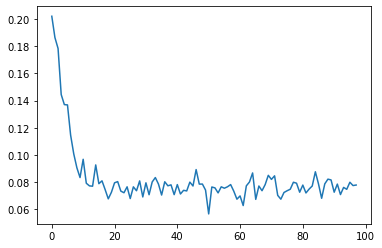

In [8]:
# Plot data
plt.plot(rmse_rnn)

In [9]:
# Save data
pk.dump(rmse_rnn, open('rnn_qasm_rmse.p', 'wb'))